In [24]:
# import packages
import pandas as pd
import numpy as np

import re
import string

import matplotlib.pyplot as plt
import seaborn as sns

# set display options
pd.set_option('display.max_colwidth', 100)

# read the data
data_path = "../data/reddit_depression.csv"
df = pd.read_csv(data_path, encoding='latin1')

# rename columns
df = df.rename(columns={"clean_text": "text", "is_depression": "label"})

# check the data
df.head()




,text,label
0,we understand that most people who reply immediately to an op with an invitation to talk private...,1.0
1,welcome to r depression s check in post a place to take a moment and share what is going on and ...,1.0
2,anyone else instead of sleeping more when depressed stay up all night to avoid the next day from...,1.0
3,i ve kind of stuffed around a lot in my life delaying the inevitable of having to work a job and...,1.0
4,sleep is my greatest and most comforting escape whenever i wake up these day the literal very fi...,1.0


In [25]:
# Data Preprocessing

df = df.dropna(subset=['text', 'label'])
df['label'].unique()


import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
# add non-sense words
custom_stopwords = set(['wa', 'ha', 'nt', 'im', 'don', 'didn', 'couldn', 'wouldn', 
                        'u', '0', 'http', 'com', 'co', 'de','wan','quot','amp','la','le','cb'])

def preprocess(text):
    tokens = text.split()
    tokens = [word for word in tokens if word not in stop_words]             # stopwords
    tokens = [word for word in tokens if word not in custom_stopwords]       # added words
    tokens = [lemmatizer.lemmatize(word) for word in tokens]                 # lemmatize
    return ' '.join(tokens)

df['processed_text'] = df['text'].apply(preprocess)



[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\滑小鱼\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\滑小鱼\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\滑小鱼\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


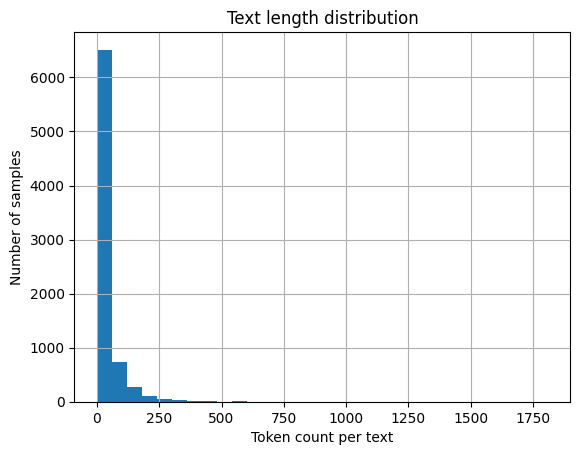

In [26]:
# text length distribution
df['text_len'] = df['processed_text'].apply(lambda x: len(x.split()))
df['text_len'].hist(bins=30)
plt.xlabel('Token count per text')
plt.ylabel('Number of samples')
plt.title('Text length distribution')
plt.show()


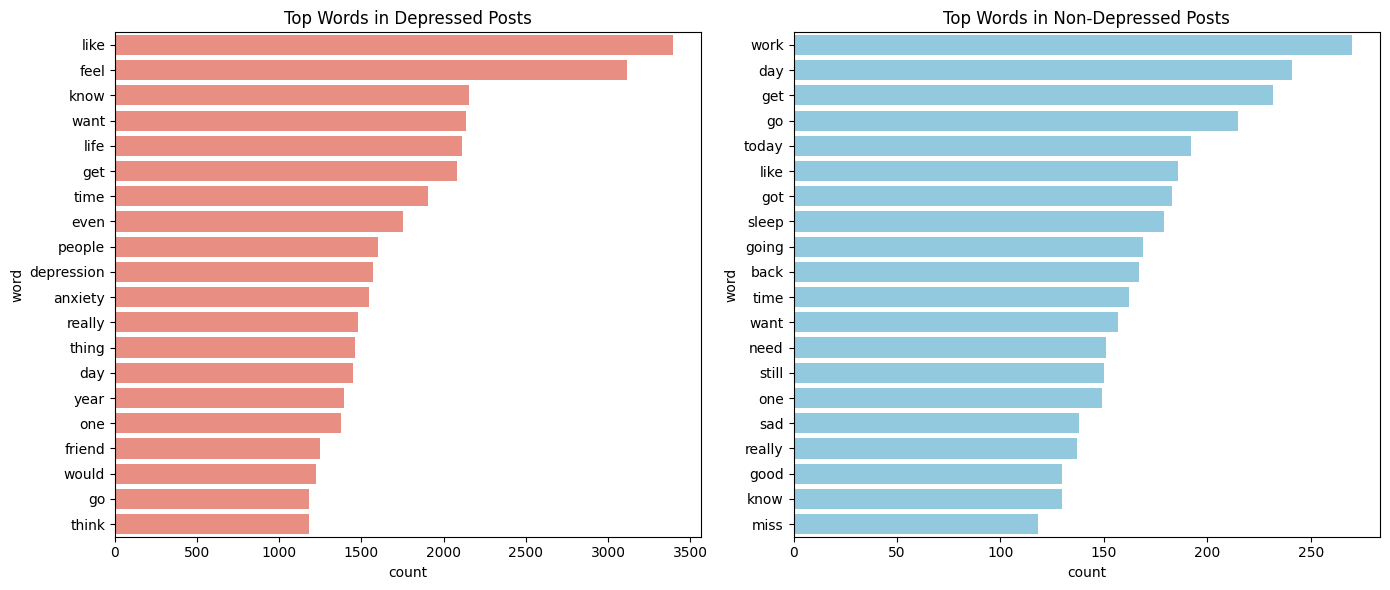

In [27]:
from collections import Counter

# function of word frequency
def get_top_n_words(corpus, n=20):
    """
    corpus: a list of texts, each element is a piece of text
    n: return the top n most frequent words
    """
    all_words = ' '.join(corpus).split()
    word_counts = Counter(all_words)
    return word_counts.most_common(n)

# depressed text
depressed_texts = df[df['label'] == 1]['processed_text']
top_words_depressed = get_top_n_words(depressed_texts)
# non-depressed text
non_depressed_texts = df[df['label'] == 0]['processed_text']
top_words_non_depressed = get_top_n_words(non_depressed_texts)

depr_df = pd.DataFrame(top_words_depressed, columns=['word', 'count'])
non_depr_df = pd.DataFrame(top_words_non_depressed, columns=['word', 'count'])

# visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
sns.barplot(data=depr_df, x='count', y='word', ax=axes[0], color='salmon')
axes[0].set_title('Top Words in Depressed Posts')
sns.barplot(data=non_depr_df, x='count', y='word', ax=axes[1], color='skyblue')
axes[1].set_title('Top Words in Non-Depressed Posts')
plt.tight_layout()
plt.show()


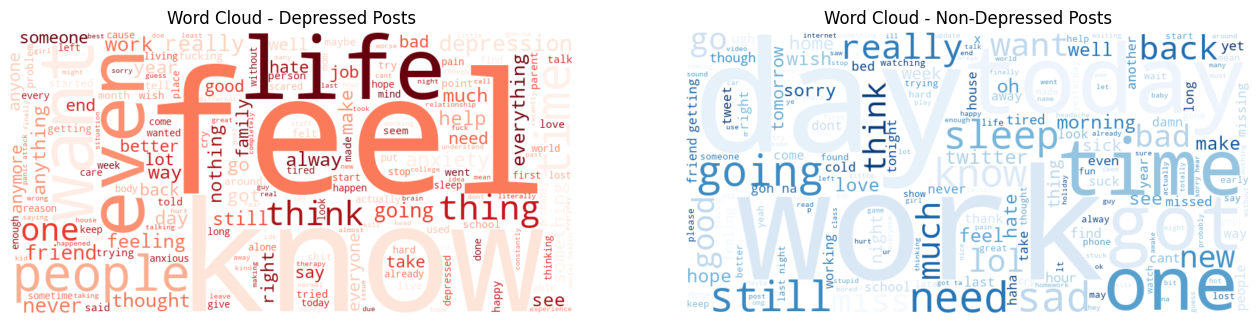

In [28]:
from wordcloud import WordCloud

# two categoories of text
text_depressed = ' '.join(df[df['label'] == 1]['processed_text'])
text_non_depressed = ' '.join(df[df['label'] == 0]['processed_text'])

# wordcloud pattern
wordcloud_depressed = WordCloud(width=800, height=400, background_color='white', colormap='Reds').generate(text_depressed)
wordcloud_non_depressed = WordCloud(width=800, height=400, background_color='white', colormap='Blues').generate(text_non_depressed)

# visulization
plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
plt.imshow(wordcloud_depressed, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud - Depressed Posts')

plt.subplot(1, 2, 2)
plt.imshow(wordcloud_non_depressed, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud - Non-Depressed Posts')

plt.show()


Top 20 TF-IDF words for Non-Depressed posts:
within: 0.0217
deserve: 0.0183
girlfriend: 0.0169
gone: 0.0167
side: 0.0160
thank: 0.0153
literally: 0.0147
awkward: 0.0144
goodbye: 0.0143
growing: 0.0142
useless: 0.0142
needed: 0.0135
space: 0.0133
test: 0.0131
result: 0.0128
middle: 0.0125
opinion: 0.0119
quite: 0.0115
lay: 0.0111
grade: 0.0108

Top 20 TF-IDF words for Depressed posts:
depression: 0.0807
like: 0.0473
feel: 0.0463
want: 0.0363
anxiety: 0.0354
know: 0.0337
life: 0.0334
get: 0.0326
people: 0.0292
time: 0.0286
even: 0.0266
day: 0.0263
really: 0.0258
one: 0.0251
thing: 0.0246
year: 0.0233
help: 0.0224
go: 0.0218
think: 0.0218
friend: 0.0213


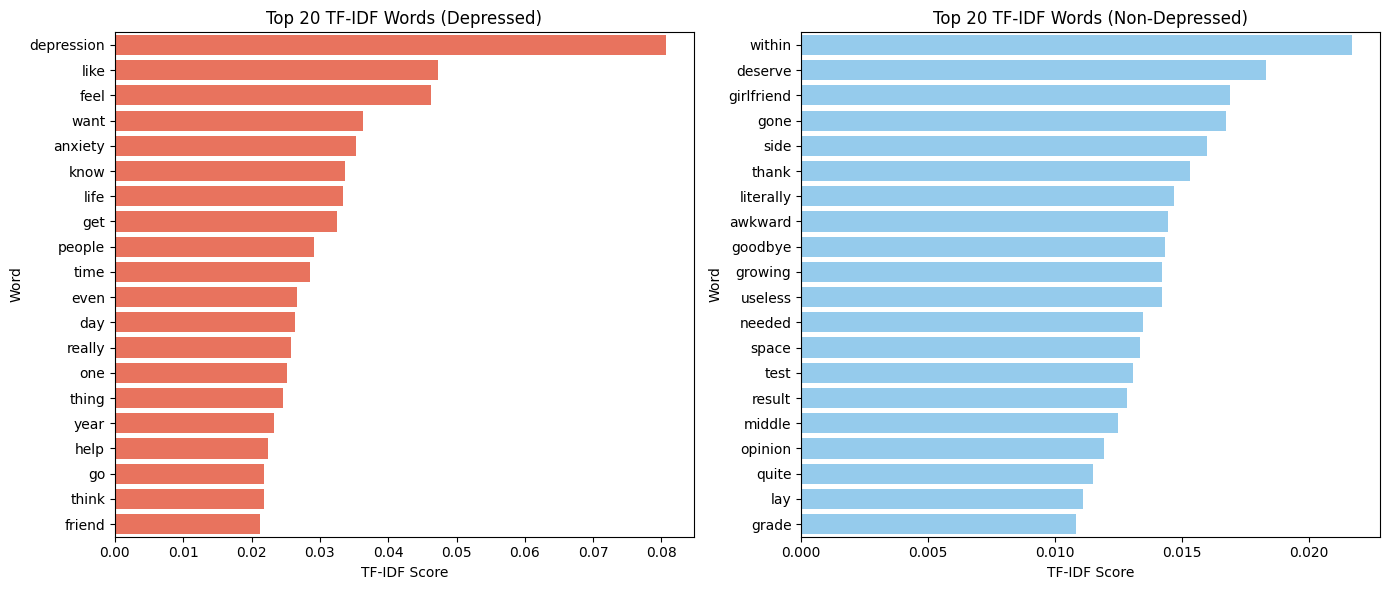

In [29]:
# TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

texts_0 = df[df['label'] == 0]['processed_text'].tolist()
texts_1 = df[df['label'] == 1]['processed_text'].tolist()

# TF-IDF
vectorizer = TfidfVectorizer(max_features=1000)
X_0 = vectorizer.fit_transform(texts_0)
X_1 = vectorizer.fit_transform(texts_1)

vocab = vectorizer.get_feature_names_out()

# mean of TF-IDF value
tfidf_mean_0 = np.asarray(X_0.mean(axis=0)).flatten()
tfidf_mean_1 = np.asarray(X_1.mean(axis=0)).flatten()

# find top 20
topn_0 = np.argsort(tfidf_mean_0)[-20:][::-1]
topn_1 = np.argsort(tfidf_mean_1)[-20:][::-1]

print("Top 20 TF-IDF words for Non-Depressed posts:")
for i in topn_0:
    print(f"{vocab[i]}: {tfidf_mean_0[i]:.4f}")

print("\nTop 20 TF-IDF words for Depressed posts:")
for i in topn_1:
    print(f"{vocab[i]}: {tfidf_mean_1[i]:.4f}")


# visualisation of top 20 TF-IDF words
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Depressed
sns.barplot(x=tfidf_mean_1[topn_1], y=vocab[topn_1], ax=axes[0], color='tomato')
axes[0].set_title('Top 20 TF-IDF Words (Depressed)')
axes[0].set_xlabel("TF-IDF Score")
axes[0].set_ylabel("Word")

# Non-Depressed
sns.barplot(x=tfidf_mean_0[topn_0], y=vocab[topn_0], ax=axes[1], color='lightskyblue')
axes[1].set_title('Top 20 TF-IDF Words (Non-Depressed)')
axes[1].set_xlabel("TF-IDF Score")
axes[1].set_ylabel("Word")

plt.tight_layout()
plt.show()



In [30]:
# Overall LDA
from gensim import corpora
from gensim.models.ldamulticore import LdaMulticore

texts = df['processed_text'].map(lambda x: x.split()).tolist()

dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

# training model
num_topics = 3  # choose 3 topics
lda_model = LdaMulticore(corpus, num_topics=num_topics, id2word=dictionary, passes=10, workers=2, random_state=42)

# print topics and words
for i, topic in lda_model.print_topics(-1):
    print(f"topic {i}: {topic}")


topic 0: 0.012*"want" + 0.012*"life" + 0.009*"time" + 0.008*"like" + 0.007*"get" + 0.006*"year" + 0.006*"day" + 0.006*"go" + 0.006*"even" + 0.006*"thing"
topic 1: 0.019*"feel" + 0.019*"like" + 0.012*"know" + 0.009*"get" + 0.009*"people" + 0.008*"even" + 0.008*"want" + 0.007*"depression" + 0.007*"anxiety" + 0.007*"time"
topic 2: 0.009*"work" + 0.008*"day" + 0.007*"sleep" + 0.007*"anxiety" + 0.007*"get" + 0.006*"back" + 0.006*"got" + 0.006*"today" + 0.005*"like" + 0.005*"going"


In [31]:
import pyLDAvis
import pyLDAvis.gensim_models

pyLDAvis_data = pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary)
html_str = pyLDAvis.prepared_data_to_html(pyLDAvis_data)

with open('lda_vis.html', 'w', encoding='utf-8') as f:
    f.write(html_str)

print("The HTML file is created: lda_vis.html")

The HTML file is created: lda_vis.html


In [32]:
# Categorical LDA
from gensim import corpora
from gensim.models.ldamulticore import LdaMulticore

df_depressed = df[df['label'] == 1]
df_non_depressed = df[df['label'] == 0]

texts_depressed = df_depressed['processed_text'].map(lambda x: x.split()).tolist()
texts_non_depressed = df_non_depressed['processed_text'].map(lambda x: x.split()).tolist()

dictionary_depressed = corpora.Dictionary(texts_depressed)
corpus_depressed = [dictionary_depressed.doc2bow(text) for text in texts_depressed]

dictionary_non_depressed = corpora.Dictionary(texts_non_depressed)
corpus_non_depressed = [dictionary_non_depressed.doc2bow(text) for text in texts_non_depressed]

# fit LDA models
num_topics = 3
lda_depressed = LdaMulticore(corpus_depressed, num_topics=num_topics, id2word=dictionary_depressed, passes=10, workers=2, random_state=42)
lda_non_depressed = LdaMulticore(corpus_non_depressed, num_topics=num_topics, id2word=dictionary_non_depressed, passes=10, workers=2, random_state=42)

# print topcs and words
print("\n--- depressed ---")
for i, topic in lda_depressed.print_topics(-1):
    print(f"Topic {i}: {topic}")

print("\n--- non-depressed ---")
for i, topic in lda_non_depressed.print_topics(-1):
    print(f"Topic {i}: {topic}")



--- depressed ---
Topic 0: 0.014*"life" + 0.013*"like" + 0.012*"feel" + 0.012*"want" + 0.010*"know" + 0.009*"get" + 0.008*"time" + 0.008*"even" + 0.008*"people" + 0.008*"friend"
Topic 1: 0.018*"like" + 0.016*"feel" + 0.013*"anxiety" + 0.010*"know" + 0.009*"get" + 0.008*"time" + 0.008*"really" + 0.008*"depression" + 0.007*"even" + 0.007*"day"
Topic 2: 0.017*"depression" + 0.010*"anxiety" + 0.006*"people" + 0.005*"help" + 0.005*"like" + 0.004*"get" + 0.004*"feel" + 0.004*"time" + 0.004*"mental" + 0.004*"health"

--- non-depressed ---
Topic 0: 0.014*"work" + 0.013*"day" + 0.008*"need" + 0.007*"got" + 0.007*"go" + 0.007*"get" + 0.006*"night" + 0.006*"back" + 0.006*"time" + 0.005*"one"
Topic 1: 0.009*"like" + 0.005*"know" + 0.005*"oh" + 0.005*"good" + 0.004*"time" + 0.004*"got" + 0.004*"really" + 0.004*"back" + 0.004*"going" + 0.004*"work"
Topic 2: 0.009*"get" + 0.008*"want" + 0.008*"still" + 0.007*"go" + 0.007*"today" + 0.006*"sleep" + 0.005*"good" + 0.004*"going" + 0.004*"really" + 0.004

In [33]:
# visualization
import pyLDAvis
import pyLDAvis.gensim_models

# depressed
pyLDAvis_data_dep = pyLDAvis.gensim_models.prepare(lda_depressed, corpus_depressed, dictionary_depressed)
html_str_dep = pyLDAvis.prepared_data_to_html(pyLDAvis_data_dep)
with open('lda_vis_depressed.html', 'w', encoding='utf-8') as f:
    f.write(html_str_dep)

# non-depressed
pyLDAvis_data_non = pyLDAvis.gensim_models.prepare(lda_non_depressed, corpus_non_depressed, dictionary_non_depressed)
html_str_non = pyLDAvis.prepared_data_to_html(pyLDAvis_data_non)
with open('lda_vis_non_depressed.html', 'w', encoding='utf-8') as f:
    f.write(html_str_non)

print("Two HTML file is created: lda_vis_depressed.html and lda_vis_non_depressed.html")


Two HTML file is created: lda_vis_depressed.html and lda_vis_non_depressed.html


In [34]:
# TF-IDF & Classification
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split

X = df['processed_text']
y = df['label']

# split training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# TF-IDF feature extraction
vectorizer = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1,2),
    min_df=2,
    max_df=0.8
)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# fit models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "SVM": SVC(kernel='linear', probability=True, random_state=42)
}

results = []

for model_name, model in models.items():
    model.fit(X_train_tfidf, y_train)
    y_pred = model.predict(X_test_tfidf)
    
    print(f"\n=== {model_name} with TF-IDF features ===")
    print(classification_report(y_test, y_pred, digits=4))
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    
    results.append({
        "Model": model_name,
        "Accuracy": round(accuracy_score(y_test, y_pred), 4),
        "Precision": round(precision_score(y_test, y_pred, average='weighted'), 4),
        "Recall": round(recall_score(y_test, y_pred, average='weighted'), 4),
        "F1-score": round(f1_score(y_test, y_pred, average='weighted'), 4)
    })

df_results = pd.DataFrame(results)
print("\nSummary:")
print(df_results)


=== Logistic Regression with TF-IDF features ===
              precision    recall  f1-score   support

         0.0     0.9386    0.9795    0.9586       780
         1.0     0.9781    0.9347    0.9559       766

    accuracy                         0.9573      1546
   macro avg     0.9584    0.9571    0.9573      1546
weighted avg     0.9582    0.9573    0.9573      1546

Confusion Matrix:
[[764  16]
 [ 50 716]]

=== Random Forest with TF-IDF features ===
              precision    recall  f1-score   support

         0.0     0.9425    0.9885    0.9650       780
         1.0     0.9876    0.9386    0.9625       766

    accuracy                         0.9638      1546
   macro avg     0.9651    0.9636    0.9637      1546
weighted avg     0.9649    0.9638    0.9637      1546

Confusion Matrix:
[[771   9]
 [ 47 719]]

=== SVM with TF-IDF features ===
              precision    recall  f1-score   support

         0.0     0.9453    0.9744    0.9596       780
         1.0     0.9730    

In [35]:
# Word2Vec & Classification
from gensim.models import Word2Vec

processed_texts = df['processed_text'].map(lambda x: x.split()).tolist()
labels = df['label'].tolist()

# train Word2Vec model
w2v_model = Word2Vec(sentences=processed_texts, vector_size=100, window=5, min_count=2, workers=4, sg=1)

# vectorize
def document_vector(doc):
    doc = [word for word in doc if word in w2v_model.wv]
    if len(doc) == 0:
        return np.zeros(w2v_model.vector_size)  # if empty, assign zero
    return np.mean(w2v_model.wv[doc], axis=0)

X = np.array([document_vector(doc) for doc in processed_texts])
y = np.array(labels)

# split training and test set
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# fit models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "SVM": SVC(kernel='linear')
}

results = []

for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    print(f"\n=== {model_name} with Word2Vec features ===")
    print(classification_report(y_test, y_pred, digits=4, zero_division=0))
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    
    results.append({
        "Model": model_name,
        "Accuracy": round(accuracy_score(y_test, y_pred), 4),
        "Precision": round(precision_score(y_test, y_pred, average='weighted', zero_division=0), 4),
        "Recall": round(recall_score(y_test, y_pred, average='weighted'), 4),
        "F1-score": round(f1_score(y_test, y_pred, average='weighted'), 4)
    })

df_results = pd.DataFrame(results)
print("\nSummary:")
print(df_results)



=== Logistic Regression with Word2Vec features ===
              precision    recall  f1-score   support

         0.0     0.8911    0.8603    0.8754       780
         1.0     0.8625    0.8930    0.8775       766

    accuracy                         0.8765      1546
   macro avg     0.8768    0.8766    0.8764      1546
weighted avg     0.8770    0.8765    0.8764      1546

Confusion Matrix:
[[671 109]
 [ 82 684]]

=== Random Forest with Word2Vec features ===
              precision    recall  f1-score   support

         0.0     0.9052    0.9551    0.9295       780
         1.0     0.9516    0.8982    0.9241       766

    accuracy                         0.9269      1546
   macro avg     0.9284    0.9267    0.9268      1546
weighted avg     0.9282    0.9269    0.9268      1546

Confusion Matrix:
[[745  35]
 [ 78 688]]

=== SVM with Word2Vec features ===
              precision    recall  f1-score   support

         0.0     0.9131    0.8487    0.8797       780
         1.0     0.85

In [36]:
# LDA & Classification
from gensim.models.ldamulticore import LdaMulticore

texts = df['processed_text'].map(lambda x: x.split()).tolist()
corpus = [dictionary.doc2bow(text) for text in texts]

# vectorize
def get_topic_dist(ldamodel, bow, num_topics):
    topic_dist = ldamodel.get_document_topics(bow, minimum_probability=0)
    topic_vec = np.zeros(num_topics)
    for topic_id, prob in topic_dist:
        topic_vec[topic_id] = prob
    return topic_vec

num_topics = lda_model.num_topics  # number of topics

X = np.array([get_topic_dist(lda_model, bow, num_topics) for bow in corpus])
y = df['label'].values

# split training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# fit models
models = {
    "Logistic Regression": LogisticRegression(max_iter=200, random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "SVM": SVC(kernel='linear', probability=True, random_state=42)
}

results = []

for model_name, model in models.items():
    print(f"\n=== {model_name} with LDA topic features ===")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    print(classification_report(y_test, y_pred, digits=4))
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    
    results.append({
        "Model": model_name,
        "Accuracy": round(accuracy_score(y_test, y_pred), 4),
        "Precision": round(precision_score(y_test, y_pred, average='weighted'), 4),
        "Recall": round(recall_score(y_test, y_pred, average='weighted'), 4),
        "F1-score": round(f1_score(y_test, y_pred, average='weighted'), 4)
    })

df_results = pd.DataFrame(results)
print("\nSummary:")
print(df_results)


=== Logistic Regression with LDA topic features ===
              precision    recall  f1-score   support

         0.0     0.7702    0.5974    0.6729       780
         1.0     0.6663    0.8185    0.7346       766

    accuracy                         0.7070      1546
   macro avg     0.7183    0.7080    0.7038      1546
weighted avg     0.7188    0.7070    0.7035      1546

Confusion Matrix:
[[466 314]
 [139 627]]

=== Random Forest with LDA topic features ===
              precision    recall  f1-score   support

         0.0     0.8402    0.8833    0.8612       780
         1.0     0.8747    0.8290    0.8512       766

    accuracy                         0.8564      1546
   macro avg     0.8574    0.8562    0.8562      1546
weighted avg     0.8573    0.8564    0.8563      1546

Confusion Matrix:
[[689  91]
 [131 635]]

=== SVM with LDA topic features ===
              precision    recall  f1-score   support

         0.0     0.7825    0.5397    0.6388       780
         1.0     0